In [6]:
import gym
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions.categorical import Categorical

import matplotlib.pyplot as plt

In [7]:
class FF(nn.Module):
    def __init__(self, input_dim=4, output_dim=2, hidden_layers=[32, 32,], activation=torch.nn.Tanh):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_layers[0])]
        hidden_layers.append(output_dim)

        for s1, s2 in zip(hidden_layers[0:-1], hidden_layers[1:]):
            layers.append(activation())
            layers.append(nn.Linear(s1, s2))

        self.mlp = nn.Sequential(*layers)
    
    def forward(self, xb):
        return F.softmax(self.mlp(xb), dim=-1)

# a = get_ff(4, 2, [10, 11, 12])

In [8]:
def rets_to_go(rewards, GAMMA):
    n = len(rewards)
    rets = []
    discs = GAMMA ** np.arange(n)
    for i in range(n):
        rets.append(sum(rewards[i:] * discs[:n-i]))
    return rets

In [9]:
def train_new(env, bs=5000, lr=0.01, epochs=50, GAMMA=0.99, logging=False,
              to_render=False, ep_thres=195, input_dim=4, output_dim=2, hidden_layers=[32, 32,],
              time_limit=800, plot_every=10):
    #bs is the total number of timesteps, not the number of trajectories
    policy_net = FF(input_dim=input_dim, output_dim=output_dim, hidden_layers=hidden_layers)
    print(policy_net)
    optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
    
    test_inp = torch.randn(8)
    with torch.no_grad():
        print(f"Initial logits for test: {policy_net(test_inp)}")
    
    def plot_info(data_name_pairs):
        print("Plotting...")
        plt.figure(figsize=[10, 30])
        n = len(data_name_pairs)
        c = 0
        
        for data, name in data_name_pairs:
            print(f"subplot ({n}, {(c//2) + 1}, {c+1})")
            plt.subplot(n, (c//2) + 1, c + 1)
            plt.plot(data, label=name)
            plt.grid(b=True, which='both')
            plt.legend(loc='upper left')
            c += 1
    
        plt.show()
    
    def train_one_iteration():
        print("Starting new iteration...")
        optimizer.zero_grad()
        total_loss = 0
        batch_returns = []; batch_actions = []; batch_obs = [];
        episode_lengths = []
        rendered_one_episode = not to_render
        episode_rews = []; losses = []
        
        obs = env.reset()
        t = 0
        
        states = []; actions = []; rewards = []
        
        while True:
            if not rendered_one_episode:
                env.render()
            
            #sample action from output(probabilities) given by NN
            action_probs = policy_net(torch.from_numpy(obs).float())
            action_dist = Categorical(probs=action_probs)
            action = action_dist.sample().detach().item()
            
            next_obs, reward, done, _ = env.step(action)
            
            states.append(obs)
            actions.append(action)
            rewards.append(reward)
            
            obs = next_obs
            t += 1
            
            if done or t >= time_limit:
                returns_to_go = rets_to_go(rewards, GAMMA)
                
                batch_actions.extend(actions)
                batch_returns.extend(returns_to_go)
                batch_obs.extend(states)
                
                states = []; actions = []; rewards = []
                obs = env.reset()
                episode_lengths.append(t)
                t = 0
                episode_rews.append(rewards)
                
                rendered_one_episode = True
                
                if len(batch_returns) >= bs:
                    states_batch = torch.FloatTensor(batch_obs)
                    action_batch = torch.LongTensor(batch_actions)
                    return_batch = torch.FloatTensor(batch_returns)
#                     print(f"batch shapes states: {states_batch.shape} \
#                     | action: {action_batch.shape} | return: {return_batch.shape}")
#                     print(f"check {return_batch.mean()} {return_batch.mean(-1)} {return_batch.mean() == return_batch.mean(-1)}")
                    
                    returns_recentered = return_batch - return_batch.mean().unsqueeze(-1)
#                     print(f"std rec: {returns_recentered.std()} returns: {return_batch.std()}")
                    returns_recentered /= returns_recentered.std()
                    
                    actions_log_probs = torch.log(policy_net(states_batch))
                    
                    # log probs of actions actually taken
                    log_probs_selected = returns_recentered * actions_log_probs[np.arange(len(action_batch)), action_batch]
                    
                    # minus for gradient ascent
                    loss = -log_probs_selected.mean()
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    losses.append(loss.detach())
                    
                    break
        
        with torch.no_grad():
            # this is for seeing changes in output for the same action throughout learning
            print(f"New logits for test: {policy_net(test_inp)}")
        
        return sum(losses) / len(losses), sum(batch_returns)/len(batch_returns), sum(episode_lengths)/len(episode_lengths), episode_rews
        
    avg_lens = []
    avg_rets = []
    avg_losses = []
    min_returns_nd = []
    max_returns_nd = []
    avg_returns_nd = []
    
    for epoch in range(epochs):
        print(f"\nEpoch #{epoch}:")
        avg_loss, avg_return, avg_length, rewards_arr = train_one_iteration()
        
        avg_lens.append(avg_length)
        avg_rets.append(avg_return)
        avg_losses.append(avg_loss)
        returns = [sum(episode_rewards) for episode_rewards in rewards_arr]
        min_returns_nd.append(min(returns))
        max_returns_nd.append(max(returns))
        avg_returns_nd.append(sum(returns) / len(returns))
        
        print(f"avg loss: {avg_loss} | avg return(discounted): {avg_return} | avg length: {avg_length}")
        print(f"min_return: {min_returns_nd[-1]} | max_return: {max(returns)}")
    
        # stop training when criterion is met
        if len(min_returns_nd) > 5:
            didnt_cross_threshold = [v >= ep_thres for v in min_returns_nd[-5:]]
            if sum(didnt_cross_threshold) == 5:
                print(f"\navg episode return >= {ep_thres} for 5 epochs\ntraining finished in {epoch+1} epochs")
                break
        
        # show graphs every one in a while
        if (epoch >= plot_every and epoch % plot_every == 0) or epoch >= epochs-1:
            plot_info([
                (avg_losses, "average loss"),
                (avg_rets, "average return (discounted)"), 
                (avg_lens, "average episode length"),
                (min_returns_nd, "minimum return"), 
                (max_returns_nd, "maximum return"),
                (avg_returns_nd, "avg return")
            ])
    
    return policy_net

In [10]:
def train(epochs=50, **kwargs):
    env = gym.make("LunarLander-v2")
    net = None
    try:
        net = train_new(env=env, epochs=epochs, GAMMA=0.99, ep_thres=200, input_dim=8, output_dim=4, hidden_layers=[64, 32], bs=2000, **kwargs)
    finally:
        env.close()
    
    return net

FF(
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)
Initial logits for test: tensor([0.2214, 0.2438, 0.3178, 0.2169])

Epoch #0:
Starting new iteration...
New logits for test: tensor([0.2127, 0.2477, 0.3371, 0.2024])
avg loss: 0.008027917705476284 | avg return(discounted): -112.78172076344678 | avg length: 103.65
min_return: -477.3081055339004 | max_return: 0

Epoch #1:
Starting new iteration...
New logits for test: tensor([0.2039, 0.2369, 0.3458, 0.2133])
avg loss: 0.006417447701096535 | avg return(discounted): -133.39246662132578 | avg length: 90.56521739130434
min_return: -467.68074803886714 | max_return: 0

Epoch #2:
Starting new iteration...
New logits for test: tensor([0.2012, 0.2186, 0.3509, 0.2293])
avg loss: 0.006467214319854975 | avg return(discounted): -136.3684831836051 | avg length: 80.4

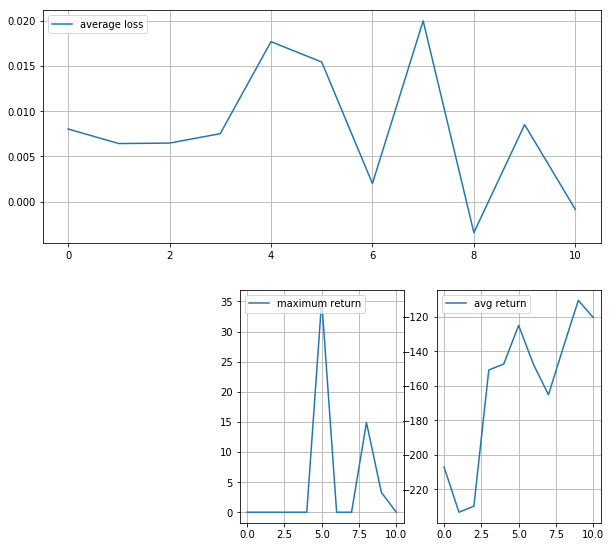


Epoch #11:
Starting new iteration...
New logits for test: tensor([0.2591, 0.1768, 0.2116, 0.3525])
avg loss: 0.013366560451686382 | avg return(discounted): -74.29366878450723 | avg length: 83.70833333333333
min_return: -327.497946049689 | max_return: 0

Epoch #12:
Starting new iteration...
New logits for test: tensor([0.2677, 0.1649, 0.2146, 0.3527])
avg loss: -0.007414413150399923 | avg return(discounted): -65.77249631065081 | avg length: 85.04166666666667
min_return: -207.27214058561032 | max_return: 0

Epoch #13:
Starting new iteration...
New logits for test: tensor([0.2806, 0.1464, 0.2139, 0.3591])
avg loss: 0.00037401056033559144 | avg return(discounted): -53.91028779744968 | avg length: 79.73076923076923
min_return: -168.06545716587652 | max_return: 0

Epoch #14:
Starting new iteration...
New logits for test: tensor([0.2978, 0.1268, 0.2137, 0.3617])
avg loss: 0.007449893746525049 | avg return(discounted): -65.95133458662116 | avg length: 86.95833333333333
min_return: -197.160241

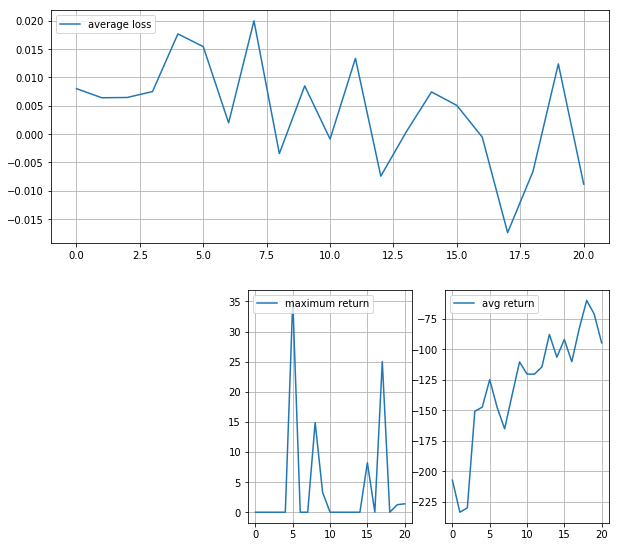


Epoch #21:
Starting new iteration...
New logits for test: tensor([0.3290, 0.0541, 0.1376, 0.4793])
avg loss: -0.008198177441954613 | avg return(discounted): -51.70202907435615 | avg length: 185.63636363636363
min_return: -308.31608484526134 | max_return: 20.642596275134892

Epoch #22:
Starting new iteration...
New logits for test: tensor([0.3263, 0.0449, 0.1071, 0.5217])
avg loss: -0.006317490246146917 | avg return(discounted): -34.966182432947264 | avg length: 263.5
min_return: -408.2821190840199 | max_return: 2.801893550906561

Epoch #23:
Starting new iteration...
New logits for test: tensor([0.3239, 0.0367, 0.0775, 0.5619])
avg loss: 0.0037461970932781696 | avg return(discounted): -42.996975742464066 | avg length: 289.2857142857143
min_return: -307.50557963748247 | max_return: 0

Epoch #24:
Starting new iteration...
New logits for test: tensor([0.3150, 0.0297, 0.0529, 0.6023])
avg loss: 0.010932809673249722 | avg return(discounted): -47.569341533263035 | avg length: 290.85714285714

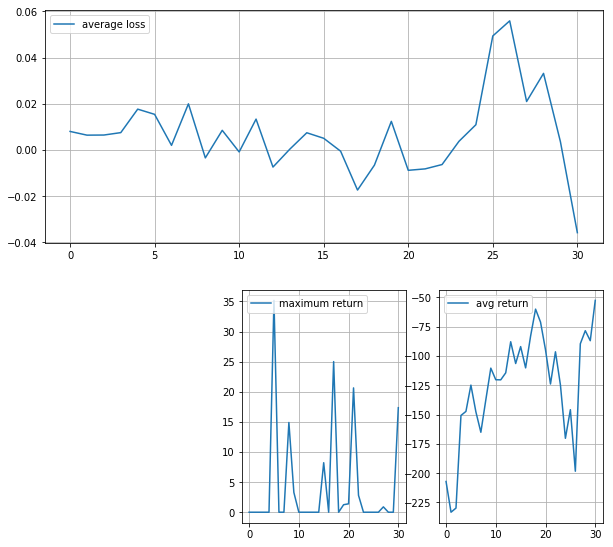


Epoch #31:
Starting new iteration...
New logits for test: tensor([0.1860, 0.0053, 0.0238, 0.7849])
avg loss: -0.0019488859688863158 | avg return(discounted): -13.944506203562746 | avg length: 332.14285714285717
min_return: -148.2652250432878 | max_return: 54.61416230354975

Epoch #32:
Starting new iteration...
New logits for test: tensor([0.1767, 0.0045, 0.0207, 0.7981])
avg loss: -0.021409358829259872 | avg return(discounted): -9.056969718716836 | avg length: 672.6666666666666
min_return: -129.00515087396187 | max_return: 0

Epoch #33:
Starting new iteration...
New logits for test: tensor([0.1669, 0.0039, 0.0187, 0.8105])
avg loss: 0.00321779097430408 | avg return(discounted): -5.51503610163472 | avg length: 425.4
min_return: -50.43160205732356 | max_return: 66.95904985663313

Epoch #34:
Starting new iteration...
New logits for test: tensor([0.1689, 0.0035, 0.0160, 0.8117])
avg loss: -0.016018152236938477 | avg return(discounted): -0.9888512054996909 | avg length: 309.3333333333333
m

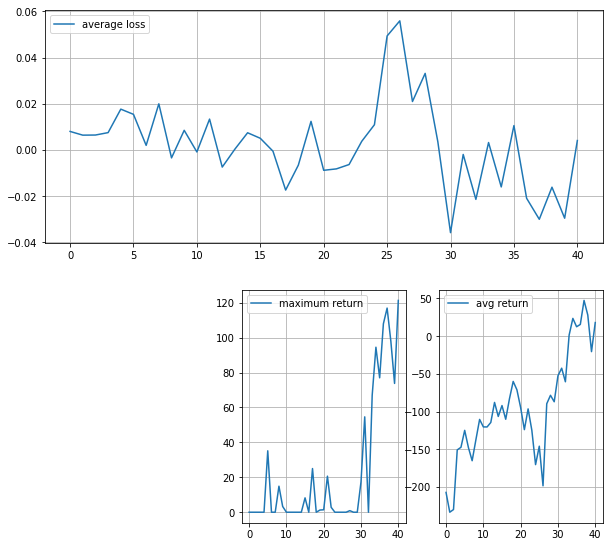


Epoch #41:
Starting new iteration...
New logits for test: tensor([0.1435, 0.0020, 0.0080, 0.8466])
avg loss: -0.041070155799388885 | avg return(discounted): 5.446302958799334 | avg length: 407.2
min_return: -14.265070845136222 | max_return: 235.9851798666329

Epoch #42:
Starting new iteration...
New logits for test: tensor([0.1378, 0.0018, 0.0073, 0.8531])
avg loss: -0.05515391752123833 | avg return(discounted): -14.647976530066941 | avg length: 409.2
min_return: -64.3807124500039 | max_return: 60.6298730966261

Epoch #43:
Starting new iteration...
New logits for test: tensor([0.1386, 0.0017, 0.0069, 0.8529])
avg loss: -0.07879814505577087 | avg return(discounted): -15.904111862456705 | avg length: 334.0
min_return: -129.8501905334807 | max_return: 107.30235092179278

Epoch #44:
Starting new iteration...
New logits for test: tensor([0.1397, 0.0015, 0.0065, 0.8523])
avg loss: -0.01454539131373167 | avg return(discounted): 9.799236182096882 | avg length: 345.5
min_return: -36.3660496536

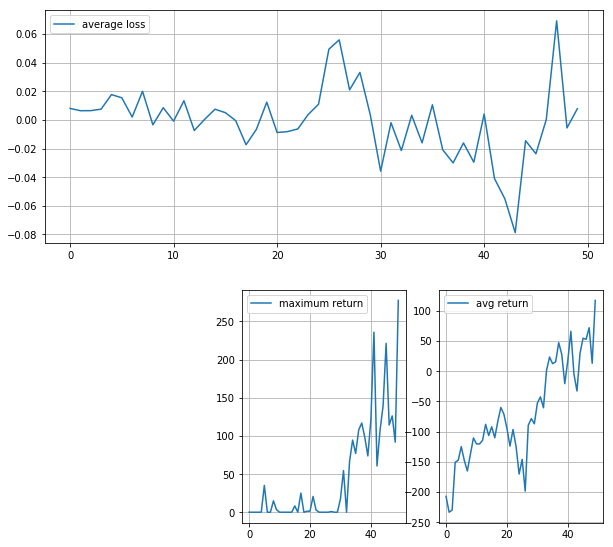

In [11]:
network = train(lr=0.01, logging=False, to_render=True)